# DT8122 - Assignment

<span style="color:red">Deadline: 2023 August 15 AoE (Anywhere on Earth)</span>

Send a zip file with the notebook both as a .ipynb and as a .pdf file to <a href="mailto:dt8122@idi.ntnu.no">dt8122@idi.ntnu.no</a>. Label the file with your full name.

The task is to implement conditional DDPM for MNIST images. Your implementation should take as input a digit and be able to generate 28x28 grayscale handwritten image of said digit. 

You can add additional cells anywhere in the notebook to make your code more readable.

DDPM: https://arxiv.org/abs/2006.11239

Classifier-free conditional DDPM: https://arxiv.org/abs/2207.12598

The notebook should be run when it is turned in so all plots are visible. All code should be contained in the notebook.


### Install necessary libraries
Any additional libraries you make use of should be installed in this cell.

<span style="color:yellow">

Instructions to run this code:
Create a new environment:
conda create -n probai python=3.10

Then run this notebook  in the environment. You might need to install ipykernel to run jupyter notebook.
</span>

In [2]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
%pip install matplotlib


Looking in indexes: https://download.pytorch.org/whl/cu117
     ---------------------------------------- 2.3/2.3 GB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 4.9/4.9 MB 15.0 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 15.7 MB/s eta 0:00:00
     ---------------------------------------- 6.5/6.5 MB 14.8 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 16.3 MB/s eta 0:00:00
     -------------------------------------- 133.1/133.1 kB 7.7 MB/s eta 0:00:00
     --------------------------------------- 14.8/14.8 MB 12.4 MB/s eta 0:00:00
     ---------------------------------------- 62.8/62.8 kB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 15.7 MB/s eta 0:00:00
     ---------------------------------------- 61.5/61.5 kB ? eta 0:00:00
     ---------------------------------------- 140.6/140.6 kB ? eta 0:00:00
     ---------------------------------------- 155.3/155.3 kB ? eta 0:00:00
     

### Import libraries
All import statements should be contained here.

In [15]:
import random
import math
import numpy as np

import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST

### Define constants here
Constants such as number of epochs, device, and learning rate and other hyperparameters should be defined here.

In [24]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED)

batch_size = 64

timesteps = 200 #for beta scheduling

### Functionality for loading and visualizing dataset
We have provided some functionality for loading and visualizing the dataset. You may add more cells/functions here.

In [3]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [4]:
"""
This function plots images in a grid. Input is a Tensor.
See show_first_batch to see how it is used.
"""
def show_images(images, title=""):
    images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(4, 4))
    cols = math.ceil(len(images) ** (1 / 2))
    rows = math.ceil(len(images) / cols)
    for r in range(rows):
        for c in range(cols):
            idx = cols * r + c
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
    fig.suptitle(title, fontsize=18)
    plt.show()

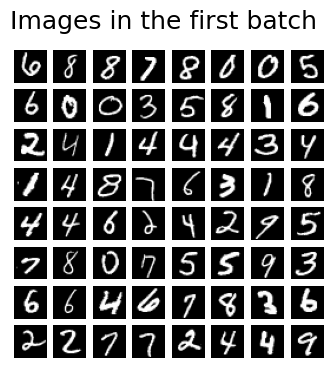

In [5]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break
show_first_batch(loader)

In [14]:
for batch in loader:
    print(batch[0][0][0].max())
    break

tensor(1.)


### Your conditional DDPM implementation should go here
This includes functionality for adding noise to the image.

In [121]:
# create a fixed beta schedule
beta = torch.linspace(0.0001, 0.02, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
# print(alpha_bar)
# print('alpha_bar',alpha_bar.shape)
# alpha_bar = torch.concatenate((torch.FloatTensor([1.]), alpha_bar[:-1]), axis=0)
# print('concat alpha_bar',alpha_bar.shape)
# print(alpha_bar)

sqrt_alpha_bar = torch.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = torch.sqrt(1-alpha_bar)

# this function will add noise to the input as per the given timestamp
def forward_diffusion(x_0, t):
    noise = torch.randn(size=x_0.shape)
    # reshaped_sqrt_alpha_bar_t = torch.reshape(torch.take(sqrt_alpha_bar, t), (-1, 1, 1))
    # print(reshaped_sqrt_alpha_bar_t)
    # reshaped_one_minus_sqrt_alpha_bar_t = torch.reshape(torch.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1))
    # noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    noisy_image = sqrt_alpha_bar[t]  * x_0 + one_minus_sqrt_alpha_bar[t]  * noise
    # print(noisy_image.shape)
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(num):
    return torch.distributions.Uniform(low=0, high=timesteps).sample(Size=[num])

Image Shape torch.Size([1, 28, 28])


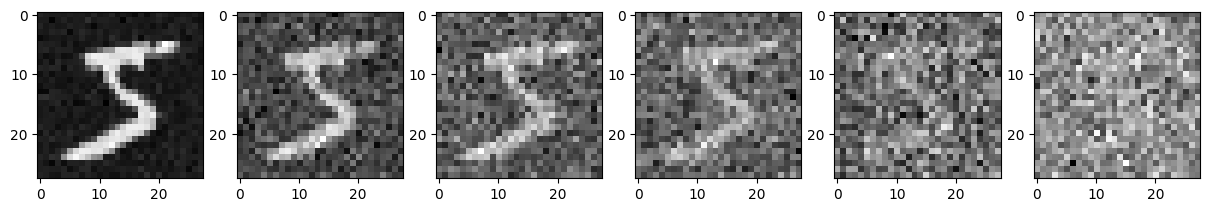

In [124]:
# Let us visualize the output image at a few timestamps
sample_mnist = dataset[0][0]
print("Image Shape",sample_mnist.shape)

fig = plt.figure(figsize=(15, 30))

test_t = [10, 50, 75, 100, 150, 195]
for index, i in enumerate(test_t):
    noisy_im, noise = forward_diffusion(sample_mnist, i)
    # print(noisy_im.shape)
    plt.subplot(1, len(test_t), index+1)
    plt.imshow(torch.squeeze(noisy_im, 0), cmap='gray')

plt.show()

In [94]:
sample_mnist = dataset[2][0]
sample_mnist.shape

torch.Size([1, 28, 28])

torch.Size([1, 1, 28, 28])
torch.Size([28, 28])


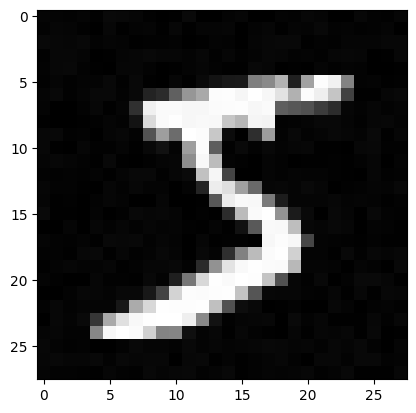

In [58]:
print(noisy_im.shape)
img = torch.squeeze(torch.squeeze(noisy_im, 0),0)
print(img.shape)
plt.imshow(torch.squeeze(torch.squeeze(noisy_im, 0),0), cmap='gray')
plt.show()

### The implementation of the neural network used to estimate the noise should go here
The network should make use of both time and context embedding.

Any functions/methods used for time and context embeddings should also go here.

### Show that you can generate images before the model is trained
This should demonstrate that the backwards pass works. The generated images are expected to be noise.

### Implement training loop
Train the model here. There should be some indication of how long the model took to train, both total and per epoch. For good results you will want to train the model for several epochs, but with a good implementation you should expect to see something that looks like digits after only a single epoch.

### Train and visualize the model
We want to see several generated examples of each digit.